## Network with multi-period battery dispatch

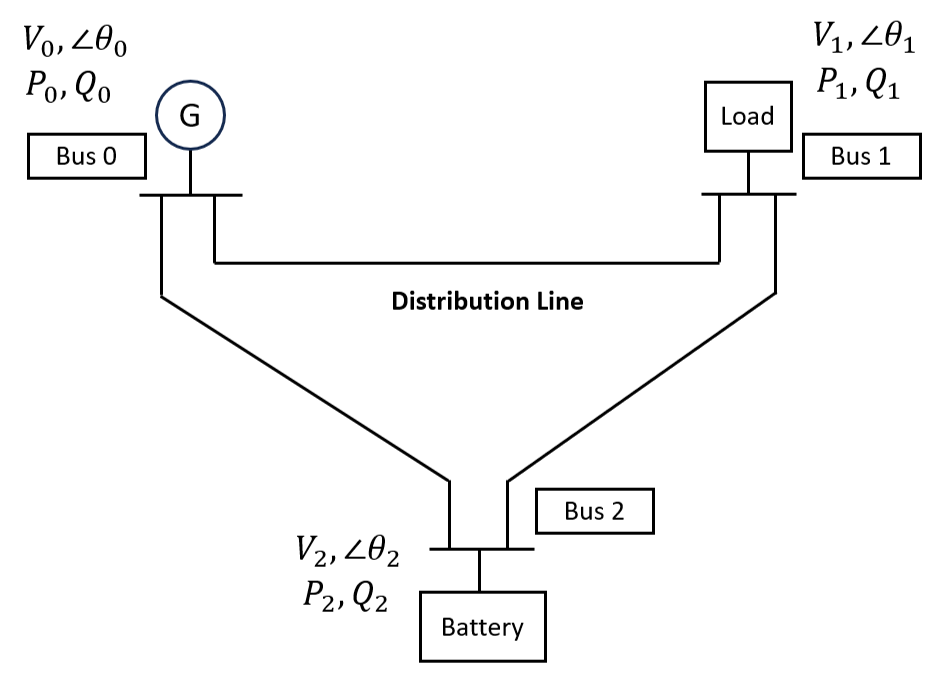

In [1]:
pip install pypsa


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -U pypsa


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Build Network

In [6]:
import numpy as np
import pandas as pd
import pypsa
import matplotlib.pyplot as plt

# =========================
# 1) Network & snapshots
# =========================
n = pypsa.Network()
snapshots = pd.date_range("2025-01-01 00:00", periods=24, freq="h")
n.set_snapshots(snapshots)
n.add("Carrier", "AC")

# =========================
# 2) 30-bus radial backbone
#    Bus 1 = substation
# =========================
root = "Bus 1"
feeder_lengths = [6, 6, 6, 6, 5]       # 1 + sum = 30
angles_deg     = [75, 140, -155, -115, -50]
STEP           = 1.6                    # visual spacing

n.add("Bus", root, v_nom=0.4, carrier="AC")
bus_pos = {root: (0.0, 0.0)}
parent  = {}
bus_id, line_id = 2, 0

for k, L in enumerate(feeder_lengths):
    theta = np.deg2rad(angles_deg[k])
    prev = root
    for j in range(1, L+1):
        name = f"Bus {bus_id}"
        x = j * STEP * np.cos(theta) + 0.5 * k
        y = j * STEP * np.sin(theta)
        n.add("Bus", name, v_nom=0.4, carrier="AC")
        bus_pos[name] = (x, y)
        n.add("Line", f"Line {line_id}", bus0=prev, bus1=name,
              r=0.06, x=0.02, s_nom=0.5, carrier="AC")
        parent[name] = prev
        prev = name
        bus_id  += 1
        line_id += 1

assert len(n.buses) == 30, f"Expected 30 buses, got {len(n.buses)}"
n.buses["x"] = pd.Series({b: bus_pos[b][0] for b in n.buses.index})
n.buses["y"] = pd.Series({b: bus_pos[b][1] for b in n.buses.index})

# =========================
# 3) Generators at Bus 2 and Bus 20
# =========================
n.add("Generator", "Gen_Bus2",
      bus="Bus 2", p_nom=0.25, p_min_pu=0.0, p_max_pu=1.0,
      marginal_cost=20.0, control="PQ")
n.add("Generator", "Gen_Bus20",
      bus="Bus 20", p_nom=0.25, p_min_pu=0.0, p_max_pu=1.0,
      marginal_cost=22.0, control="PQ")

# =========================
# 4) Users: two per bus on all buses except {1,2,20}
#    Split: 24 PV (green), 10 Battery (yellow), 20 Load-only (pink)
# =========================
USER_OFFSET = 0.55    # distance from bus for user markers
LOAD_COLOR  = "#ff69b4"   # pink
PV_COLOR    = "#2ecc71"   # green
BAT_COLOR   = "#f1c40f"   # yellow

# PV profile (capacity factor) → availability only (we keep constant costs)
pv_cf = [0,0,0,0,0.05,0.15,0.35,0.55,0.75,0.90,0.95,0.90,
         0.70,0.55,0.35,0.15,0.05,0,0,0,0,0,0,0]
pv_series = pd.Series(pv_cf, index=n.snapshots).clip(0,1)
n.generators_t.p_max_pu = pd.DataFrame(1.0, index=n.snapshots, columns=[])

# Build user slots for buses 3..30 except 20  -> 27 buses * 2 = 54 users
buses_for_users = [f"Bus {i}" for i in range(3, 31) if i != 20]
user_slots = [(b, t) for b in buses_for_users for t in ("A", "B")]
assert len(user_slots) == 54

# Deterministic role assignment
N_PV, N_BAT, N_LOAD = 24, 10, 20
rng  = np.random.default_rng(42)
perm = rng.permutation(len(user_slots))
pv_idx   = set(perm[:N_PV])
bat_idx  = set(perm[N_PV:N_PV+N_BAT])
load_idx = set(perm[N_PV+N_BAT:])
assert len(pv_idx) == N_PV and len(bat_idx) == N_BAT and len(load_idx) == N_LOAD

def unit_perp(p, q):
    vx, vy = q[0]-p[0], q[1]-p[1]
    if vx == 0.0 and vy == 0.0:
        return (0.0, 1.0)
    px, py = -vy, vx
    nrm = (px**2 + py**2)**0.5
    return (px/nrm, py/nrm)

users_pos = {}
pv_users, bat_users, load_users = [], [], []

for idx, (bus, tag) in enumerate(user_slots):
    # compute left/right marker position, perpendicular to incoming line
    p = bus_pos[parent[bus]]; q = bus_pos[bus]
    ux, uy = unit_perp(p, q)
    bx, by = q
    offset = USER_OFFSET if tag == "A" else -USER_OFFSET
    uxpt, uypt = bx + offset*ux, by + offset*uy

    uname = f"{bus}_User{tag}"
    users_pos[uname] = (uxpt, uypt)

    if idx in pv_idx:
        # PV user (Generator) with constant costs  ← UPDATED
        n.add("Generator", f"{uname}_PV",
              bus=bus, carrier="solar",
              p_nom=0.003,                 # 3 kW
              p_min_pu=0.0, p_max_pu=1.0,
              marginal_cost=0.5,           # constant linear cost
              marginal_cost_quadratic=1.2, # constant quadratic cost
              control="PQ")
        n.generators_t.p_max_pu[f"{uname}_PV"] = pv_series  # availability only
        pv_users.append(uname)
    elif idx in bat_idx:
        n.add("StorageUnit", f"{uname}_Bat", bus=bus, carrier="battery",
              p_nom=0.005, max_hours=2.0,  # 5 kW / 10 kWh
              efficiency_store=0.95, efficiency_dispatch=0.95,
              standing_loss=0.001,
              marginal_cost=0.005, marginal_cost_quadratic=0.05, capital_cost=0.0)
        bat_users.append(uname)
    else:
        kw = 2.0 + (hash(uname) % 4)  # 2,3,4,5 kW
        n.add("Load", f"{uname}_Load", bus=bus, p_set=kw/1000.0)
        load_users.append(uname)

print(f"Users -> Load-only: {len(load_users)}, PV: {len(pv_users)}, Battery: {len(bat_users)}")




Users -> Load-only: 20, PV: 24, Battery: 10


Visulise Network

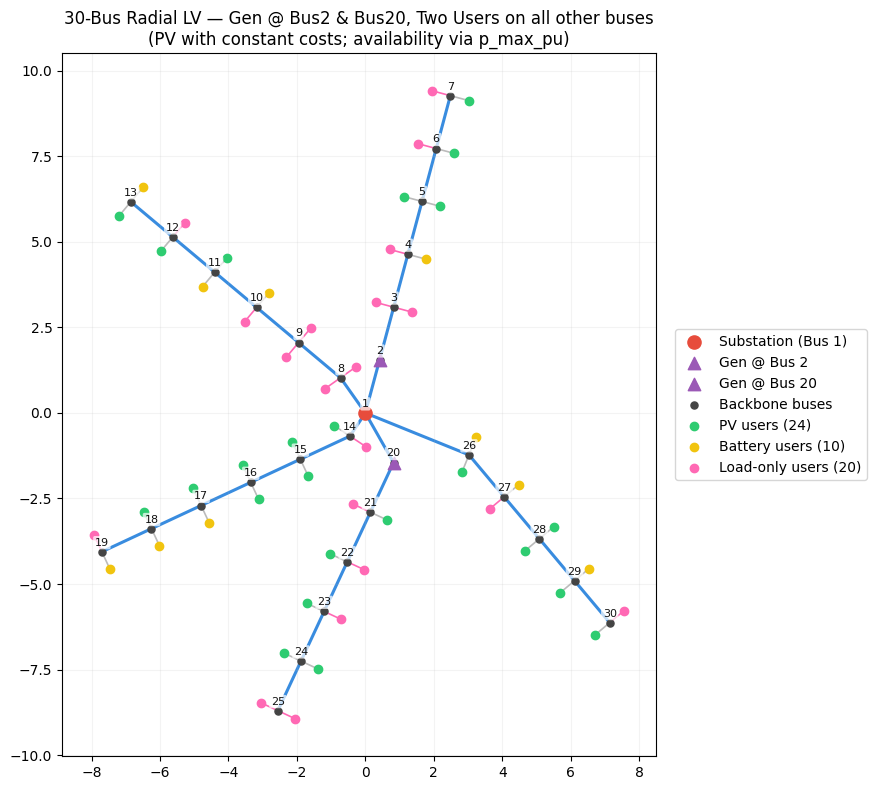

In [7]:
# =========================
# 5) Plot: lines, buses, gens, connectors + markers, labels
# =========================
fig, ax = plt.subplots(figsize=(12, 8))

# backbone lines
for _, row in n.lines.iterrows():
    x0, y0 = bus_pos[row.bus0]; x1, y1 = bus_pos[row.bus1]
    ax.plot([x0, x1], [y0, y1], color="#2e86de", lw=2.2, alpha=0.95, zorder=1)

# buses
bx = [bus_pos[b][0] for b in n.buses.index]
by = [bus_pos[b][1] for b in n.buses.index]
bus_sc = ax.scatter(bx, by, s=26, c="#444444", zorder=2, label="Backbone buses")

# substation + generators
rx, ry = bus_pos[root]
root_sc = ax.scatter([rx], [ry], s=90, c="#e74c3c", zorder=4, label="Substation (Bus 1)")
g2x, g2y = bus_pos["Bus 2"]
g20x, g20y = bus_pos["Bus 20"]
g2_sc  = ax.scatter([g2x],  [g2y],  s=80, c="#9b59b6", marker="^", zorder=4, label="Gen @ Bus 2")
g20_sc = ax.scatter([g20x], [g20y], s=80, c="#9b59b6", marker="^", zorder=4, label="Gen @ Bus 20")

# connectors (bus -> user)
def draw_connectors(names, color, lw=1.2):
    for uname in names:
        b = uname.split("_User")[0]
        x0, y0 = bus_pos[b]
        x1, y1 = users_pos[uname]
        ax.plot([x0, x1], [y0, y1], color=color, lw=lw, zorder=1)

draw_connectors(pv_users,  color="#BBBBBB")
draw_connectors(bat_users, color="#BBBBBB")
draw_connectors(load_users, color=LOAD_COLOR)  # pink connectors for loads

# user markers
def scatter_group(names, color, label):
    if not names: return None
    xs = [users_pos[u][0] for u in names]; ys = [users_pos[u][1] for u in names]
    return ax.scatter(xs, ys, s=36, c=color, zorder=5, label=label)

h_pv   = scatter_group(pv_users,   PV_COLOR,   "PV users (24)")
h_bat  = scatter_group(bat_users,  BAT_COLOR,  "Battery users (10)")
h_load = scatter_group(load_users, LOAD_COLOR, "Load-only users (20)")

# label each bus with its number
for b in n.buses.index:
    x, y = bus_pos[b]
    num = b.split()[-1]
    ax.text(x, y + 0.12, num, fontsize=8, ha="center", va="bottom", color="#111",
            bbox=dict(boxstyle="round,pad=0.15", fc="white", ec="none", alpha=0.7),
            zorder=6)

# cosmetics
ax.set_title("30-Bus Radial LV — Gen @ Bus2 & Bus20, Two Users on all other buses\n(PV with constant costs; availability via p_max_pu)")
ax.set_aspect("equal", "box"); ax.grid(True, alpha=0.15)

# padding
all_x = np.array(bx + [p[0] for p in users_pos.values()])
all_y = np.array(by + [p[1] for p in users_pos.values()])
padx = max(0.6, 0.06*(all_x.max()-all_x.min()))
pady = max(0.6, 0.06*(all_y.max()-all_y.min()))
ax.set_xlim(all_x.min()-padx, all_x.max()+padx)
ax.set_ylim(all_y.min()-pady, all_y.max()+pady)

# legend outside (mid-right)
handles = [root_sc, g2_sc, g20_sc, bus_sc, h_pv, h_bat, h_load]
handles = [h for h in handles if h is not None]
ax.legend(handles=handles, loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=True)
fig.subplots_adjust(right=0.80)
plt.tight_layout()


### Build Network Model

#### Add **User A, B ,C** to the existing Network 

In [ ]:
# Solve (QP with HiGHS)

res = n.optimize()

#### Display User Accounting Ledger

In [ ]:
# 1) Snapshot weighting (usually 1 h per snapshot)
w = n.snapshot_weightings["objective"].reindex(n.snapshots)

# 2) Nodal prices (LMPs). If not present, fill with NaN (or set a fallback).
try:
    lmp = n.buses_t.marginal_price.copy()
except Exception:
    lmp = pd.DataFrame(np.nan, index=n.snapshots, columns=n.buses.index)

def lmp_at(bus_name: str) -> pd.Series:
    return lmp[bus_name] if bus_name in lmp.columns else pd.Series(np.nan, index=n.snapshots)

# 3) Pull user time series
ua_name = "UserA_PV"
ub_name = "UserB_Battery"
uc_name = "UserC_Load"

ua_bus = n.generators.at[ua_name, "bus"]
ub_bus = n.storage_units.at[ub_name, "bus"]
uc_bus = n.loads.at[uc_name, "bus"]

ua_p = n.generators_t.p[ua_name]              # MW (>=0)
ub_p = n.storage_units_t.p[ub_name]           # MW (+discharge, -charge)
uc_p = n.loads_t.p_set.get(uc_name, pd.Series(0.0, index=n.snapshots))  # MW

# 4) Energy per snapshot (MWh)
ua_e   = ua_p * w
ub_sell = ub_p.clip(lower=0.0) * w
ub_buy  = (-ub_p.clip(upper=0.0)) * w
uc_e   = uc_p * w

# 5) Prices per snapshot
price_A = lmp_at(ua_bus)
price_B = lmp_at(ub_bus)
price_C = lmp_at(uc_bus)

# 6) COSTS
# User A (Generator): linear may be time-varying; quadratic usually scalar
def gen_mc_series(gen_name: str) -> pd.Series:
    if "marginal_cost" in n.generators_t and gen_name in n.generators_t.marginal_cost:
        return n.generators_t.marginal_cost[gen_name].reindex(n.snapshots)
    else:
        return pd.Series(n.generators.at[gen_name, "marginal_cost"], index=n.snapshots)

ua_mc_ts  = gen_mc_series(ua_name)  # £/MWh
ua_mc2    = float(n.generators.get("marginal_cost_quadratic",
                                   pd.Series(0.0, index=n.generators.index)).get(ua_name, 0.0))

# Correct weighting: w * (c * p + c2 * p^2)
ua_cost_lin_ts  = w * ua_mc_ts * ua_p
ua_cost_quad_ts = w * ua_mc2 * (ua_p ** 2)
ua_cost_total_ts = ua_cost_lin_ts + ua_cost_quad_ts

# User B (StorageUnit): cost only on discharge (p>0)
def su_mc_series(su_name: str) -> pd.Series:
    # if you ever set n.storage_units_t.marginal_cost, this will pick it up
    if "marginal_cost" in n.storage_units_t and su_name in n.storage_units_t.marginal_cost:
        return n.storage_units_t.marginal_cost[su_name].reindex(n.snapshots)
    else:
        return pd.Series(n.storage_units.at[su_name, "marginal_cost"], index=n.snapshots)

ub_mc_ts = su_mc_series(ub_name)
ub_mc2   = float(n.storage_units.get("marginal_cost_quadratic",
                                     pd.Series(0.0, index=n.storage_units.index)).get(ub_name, 0.0))
ub_p_pos = ub_p.clip(lower=0.0)

ub_cost_lin_ts  = w * ub_mc_ts * ub_p_pos
ub_cost_quad_ts = w * ub_mc2 * (ub_p_pos ** 2)
ub_cost_total_ts = ub_cost_lin_ts + ub_cost_quad_ts

# 7) Cashflows per snapshot (positive = revenue to user; negative = payment by user)
ua_revenue_ts = price_A * ua_e
ub_cash_ts    = price_B * ub_sell - price_B * ub_buy - ub_cost_total_ts
uc_cash_ts    = - price_C * uc_e

# Net for User A (revenue minus own costs)
ua_cash_net_ts = ua_revenue_ts - ua_cost_total_ts

# 8) Assemble per-snapshot ledger
ledger = pd.DataFrame({
    # Energies
    "UserA_energy_MWh": ua_e,
    "UserB_discharge_MWh": ub_sell,
    "UserB_charge_MWh": ub_buy,
    "UserC_energy_MWh": uc_e,

    # Prices
    "Price_UserA_bus": price_A,
    "Price_UserB_bus": price_B,
    "Price_UserC_bus": price_C,

    # User A costs (gen)
    "UserA_cost_lin": ua_cost_lin_ts,
    "UserA_cost_quad": ua_cost_quad_ts,

    # User B costs (battery discharge only)
    "UserB_cost_lin": ub_cost_lin_ts,
    "UserB_cost_quad": ub_cost_quad_ts,

    # Cashflows
    "UserA_revenue": ua_revenue_ts,
    "UserA_cashflow_net": ua_cash_net_ts,     # revenue - own costs
    "UserB_cashflow": ub_cash_ts,
    "UserC_cashflow": uc_cash_ts
}, index=n.snapshots)

# 9) Totals (useful for settlement)
totals = pd.Series({
    # Energy
    "UserA_energy_MWh": ua_e.sum(),
    "UserB_discharge_MWh": ub_sell.sum(),
    "UserB_charge_MWh": ub_buy.sum(),
    "UserC_energy_MWh": uc_e.sum(),

    # User A costs & revenues
    "UserA_cost_lin_total": ua_cost_lin_ts.sum(),
    "UserA_cost_quad_total": ua_cost_quad_ts.sum(),
    "UserA_revenue_total": ua_revenue_ts.sum(),
    "UserA_net_cash_total": ua_cash_net_ts.sum(),

    # User B costs & net cash
    "UserB_cost_lin_total": ub_cost_lin_ts.sum(),
    "UserB_cost_quad_total": ub_cost_quad_ts.sum(),
    "UserB_cashflow_total": ub_cash_ts.sum(),   # >0 net revenue, <0 net payment

    # User C payment (positive number paid)
    "UserC_payment_total": (-uc_cash_ts).sum()
})

print("\n=== OPF-P2P per-snapshot ledger (head) ===")
print(ledger.head())
print("\n=== OPF-P2P settlement totals ===")
print(totals)

# 10) Export
ledger.to_csv("opf_p2p_ledger_timeseries.csv", index=True)
totals.to_csv("opf_p2p_ledger_totals.csv", header=False)
print("\nSaved:")
print(" - opf_p2p_ledger_timeseries.csv")
print(" - opf_p2p_ledger_totals.csv")

### Display the output - Generator and Battery

In [ ]:
# ---------------------------
# Results (with small-negative clipping for readability)
# ---------------------------
def clip_small(df, tol=1e-6):
    out = df.copy()
    out[(out.abs() < tol)] = 0.0
    return out

print("\n=== Generator Active Power Outputs (MW) ===")
pg = clip_small(n.generators_t.p)
print(pg)

print("\n=== Storage Power (MW, +discharge, -charge) ===")
ps = clip_small(n.storage_units_t.p)
print(ps)

print("\n=== Storage State of Charge (MWh) ===")
print(n.storage_units_t.state_of_charge)


# ---------------------------
# User-focused outputs
# ---------------------------
ua, ub, uc = "UserA_PV", "UserB_Battery", "UserC_Load"

def clip_small_any(x, tol=1e-6):
    # works for Series or DataFrame
    if isinstance(x, pd.Series):
        out = x.copy()
        out[(out.abs() < tol)] = 0.0
        return out
    else:
        out = x.copy()
        out[(out.abs() < tol)] = 0.0
        return out

# Snapshot weighting (usually 1h)
w = n.snapshot_weightings["objective"].reindex(n.snapshots)

# --- User A (PV) ---
print("\n=== User A (PV) Output (MW) ===")
ua_p = n.generators_t.p[ua]
print(clip_small_any(ua_p))

ua_energy = (ua_p * w).sum()  # MWh over the horizon
print(f"User A total energy exported: {ua_energy:.3f} MWh")

# --- User B (Battery) ---
print("\n=== User B (Battery) Power (MW, +discharge, -charge) ===")
ub_p = n.storage_units_t.p[ub]
print(clip_small_any(ub_p))

# SOC (MWh) + SOC%
print("\n=== User B (Battery) State of Charge (MWh and %) ===")
ub_soc = n.storage_units_t.state_of_charge[ub]

# capacity (MWh)
if "state_of_charge_nom" in n.storage_units.columns:
    ub_cap = float(n.storage_units.at[ub, "state_of_charge_nom"])
else:
    ub_cap = float(n.storage_units.at[ub, "p_nom"] * n.storage_units.at[ub, "max_hours"])

print(ub_soc.rename("UserB_SOC_MWh"))
print((ub_soc / ub_cap * 100.0).rename("UserB_SOC_%"))

ub_discharge_mwh = (ub_p.clip(lower=0.0) * w).sum()
ub_charge_mwh    = (-ub_p.clip(upper=0.0) * w).sum()
print(f"User B discharged energy: {ub_discharge_mwh:.3f} MWh")
print(f"User B charged energy:    {ub_charge_mwh:.3f} MWh")

# --- User C (Load) ---
print("\n=== User C (Load) Demand (MW) ===")
# Prefer actual supplied load if available; otherwise p_set
if hasattr(n.loads_t, "p") and uc in n.loads_t.p.columns:
    uc_p = n.loads_t.p[uc]
else:
    uc_p = n.loads_t.p_set[uc]
print(clip_small_any(uc_p))

uc_energy = (uc_p * w).sum()
print(f"User C total energy consumed: {uc_energy:.3f} MWh")



### Plot the output - Generator and Battery

In [ ]:
import matplotlib.pyplot as plt

ua, ub = "UserA_PV", "UserB_Battery"
pg_to_plot = pg[[c for c in pg.columns if not c.startswith("_SUinj_")]]

fig, ax = plt.subplots(figsize=(11, 5))
pg_to_plot.plot(ax=ax, alpha=0.6, legend=False)  # no legend for the many base lines

# Emphasize User A + overlay User B
if ua in n.generators_t.p.columns:
    n.generators_t.p[ua].plot(ax=ax, linewidth=3, label="UserA_PV", zorder=5)
if ub in n.storage_units_t.p.columns:
    n.storage_units_t.p[ub].plot(ax=ax, linewidth=2, linestyle="--",
                                 label="UserB_Battery (+discharge/−charge)", zorder=4)

ax.axhline(0, linestyle=":", linewidth=1, color="gray")
ax.set_title("Active Power Output — Generators + UserB Battery")
ax.set_xlabel("Snapshot"); ax.set_ylabel("P (MW)")
ax.grid(True, which="both", axis="y", alpha=0.3)

ax.legend(loc="center right", frameon=True)  # ← mid-right
plt.tight_layout()



In [ ]:

ps = n.storage_units_t.p

# Define SOC time series
soc = n.storage_units_t.state_of_charge

# Capacity per unit (MWh)
if "state_of_charge_nom" in n.storage_units.columns:
    cap = n.storage_units["state_of_charge_nom"]
else:  # fallback for older PyPSA
    cap = n.storage_units["p_nom"] * n.storage_units.get("max_hours", 1.0)

# Align columns (just in case)
units = n.storage_units.index
ps = ps.reindex(columns=units)
soc = soc.reindex(columns=units)
cap = cap.reindex(units)

# SOC % per unit
soc_pct_per_unit = soc.divide(cap, axis=1) * 100

# ---- Plot: per-unit power (left) and SOC% (right) with matching colors ----
fig, ax1 = plt.subplots(figsize=(11, 5))
ax2 = ax1.twinx()

# color cycle
from itertools import cycle
colors = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

handles = []
labels = []

for unit, color in zip(units, colors):
    # Power (solid)
    h1 = ax1.plot(ps.index, ps[unit], label=f"{unit} power (MW)", color=color, linewidth=2)[0]
    # SOC% (dashed) with same color
    h2 = ax2.plot(soc_pct_per_unit.index, soc_pct_per_unit[unit],
                  label=f"{unit} SOC (%)", color=color, linestyle="--", linewidth=2)[0]
    handles += [h1, h2]
    labels  += [h1.get_label(), h2.get_label()]

ax1.axhline(0, linestyle=":", linewidth=1, color="gray")
ax1.set_title("Storage: Power (per unit) and SOC (%)")
ax1.set_xlabel("Snapshot")
ax1.set_ylabel("Power (MW)")
ax2.set_ylabel("SOC (%)")

# Make axes a bit clearer
ax1.grid(True, which="both", axis="y", alpha=0.3)

# One combined legend
ax1.legend(handles, labels, loc="upper right", frameon=True)
plt.tight_layout()

ub = "UserB_Battery"  # convenience alias

# ↓↓↓ existing combined plot, just change the legend placement ↓↓↓
ax1.legend(handles, labels, loc="lower left", frameon=True)  # was "upper right"
plt.tight_layout()

# --- New: dedicated User B panel (power + SOC%) ---
if ub in units:
    fig, ax1b = plt.subplots(figsize=(11, 4))
    ax2b = ax1b.twinx()

    # Emphasize User B power (solid) and SOC% (dashed)
    h1b = ax1b.plot(ps.index, ps[ub], linewidth=3, label="UserB power (MW)")[0]
    h2b = ax2b.plot(soc_pct_per_unit.index, soc_pct_per_unit[ub],
                    linestyle="--", linewidth=3, label="UserB SOC (%)")[0]

    ax1b.axhline(0, linestyle=":", linewidth=1, color="gray")
    ax1b.set_title("User B Battery — Power and SOC%")
    ax1b.set_xlabel("Snapshot")
    ax1b.set_ylabel("Power (MW)")
    ax2b.set_ylabel("SOC (%)")
    ax1b.grid(True, which="both", axis="y", alpha=0.3)

    # Bottom-left legend for this panel too
    ax1b.legend([h1b, h2b], [h1b.get_label(), h2b.get_label()],
                loc="lower left", frameon=True)

    plt.tight_layout()
else:
    print("[Info] UserB_Battery not in n.storage_units.index; skipping dedicated panel.")

    # ... everything above stays the same ...

ax1.axhline(0, linestyle=":", linewidth=1, color="gray")
ax1.set_title("Storage: Power (per unit) and SOC (%)")
ax1.set_xlabel("Snapshot")
ax1.set_ylabel("Power (MW)")
ax2.set_ylabel("SOC (%)")
ax1.grid(True, which="both", axis="y", alpha=0.3)

# One combined legend at mid-left (inside the axes)
ax1.legend(handles, labels, loc="center left", frameon=True)
plt.tight_layout()






### Cost Breakdown - Generator and Battery

In [ ]:
w = n.snapshot_weightings["objective"].reindex(n.snapshots)  # hours in objective

# ---------------------------
# Generators (incl. UserA_PV)
# ---------------------------
# MW dispatch (T x G)
p_gen = n.generators_t.p.reindex(index=n.snapshots, columns=n.generators.index).fillna(0.0)

# Build hourly marginal_cost table (T x G): start from constants, overwrite with any time-varying
mc_gen_ts = pd.DataFrame(
    np.tile(n.generators["marginal_cost"].values, (len(n.snapshots), 1)),
    index=n.snapshots, columns=n.generators.index
)
if hasattr(n.generators_t, "marginal_cost") and not n.generators_t.marginal_cost.empty:
    # Overwrite the columns that exist in the time-varying table
    for col in n.generators_t.marginal_cost.columns.intersection(n.generators.index):
        mc_gen_ts[col] = n.generators_t.marginal_cost[col].reindex(n.snapshots).fillna(mc_gen_ts[col])

# Quadratic coefficients (G)
mc2_gen = n.generators.get(
    "marginal_cost_quadratic",
    pd.Series(0.0, index=n.generators.index)
).reindex(n.generators.index).fillna(0.0)

# Costs per snapshot (T x G), then sum over time → (G)
gen_cost_lin_ts  = (p_gen * mc_gen_ts).mul(w, axis=0)
gen_cost_quad_ts = ((p_gen ** 2) * mc2_gen).mul(w, axis=0)

gen_lin  = gen_cost_lin_ts.sum(axis=0)
gen_quad = gen_cost_quad_ts.sum(axis=0)
gen_opex = gen_lin + gen_quad

gen_breakdown = pd.DataFrame({
    "lin": gen_lin,
    "quad": gen_quad,
    "total": gen_opex
}).sort_values("total")

print("\n=== Manual OPEX — Generators (per asset) ===")
print(gen_breakdown)

# ---------------------------
# StorageUnits (incl. UserB_Battery) — discharge only
# ---------------------------
p_su = n.storage_units_t.p.reindex(index=n.snapshots, columns=n.storage_units.index).fillna(0.0)
p_su_pos = p_su.clip(lower=0.0)  # discharge MW only

# Hourly marginal_cost table (T x S)
mc_su_ts = pd.DataFrame(
    np.tile(n.storage_units["marginal_cost"].values, (len(n.snapshots), 1)),
    index=n.snapshots, columns=n.storage_units.index
)
if hasattr(n.storage_units_t, "marginal_cost") and not n.storage_units_t.marginal_cost.empty:
    for col in n.storage_units_t.marginal_cost.columns.intersection(n.storage_units.index):
        mc_su_ts[col] = n.storage_units_t.marginal_cost[col].reindex(n.snapshots).fillna(mc_su_ts[col])

# Quadratic coefficients (S)
mc2_su = n.storage_units.get(
    "marginal_cost_quadratic",
    pd.Series(0.0, index=n.storage_units.index)
).reindex(n.storage_units.index).fillna(0.0)

su_cost_lin_ts  = (p_su_pos * mc_su_ts).mul(w, axis=0)
su_cost_quad_ts = ((p_su_pos ** 2) * mc2_su).mul(w, axis=0)

su_lin  = su_cost_lin_ts.sum(axis=0)
su_quad = su_cost_quad_ts.sum(axis=0)
su_opex = su_lin + su_quad

su_breakdown = pd.DataFrame({
    "lin": su_lin,
    "quad": su_quad,
    "total": su_opex
}).sort_values("total")

print("\n=== Manual OPEX — StorageUnits (per asset, discharge-only costs) ===")
print(su_breakdown)

# ---------------------------
# Highlights for OPF-P2P users
# ---------------------------
ua, ub = "UserA_PV", "UserB_Battery"

if ua in gen_breakdown.index:
    r = gen_breakdown.loc[ua]
    print(f"\n[User A] OPEX — lin: {r['lin']:.6g}, quad: {r['quad']:.6g}, total: {r['total']:.6g}")

if ub in su_breakdown.index:
    r = su_breakdown.loc[ub]
    print(f"[User B] OPEX — lin: {r['lin']:.6g}, quad: {r['quad']:.6g}, total: {r['total']:.6g}")

# ---------------------------
# System totals
# ---------------------------
system_opex = gen_opex.sum() + su_opex.sum()
print(f"\n=== System OPEX total (Generators + StorageUnits): {system_opex:.6g} ===")

### Unit Commitment of Generator

In [ ]:
# ---------- Derive "unit commitment" (UC) from economic dispatch ----------

# Anything above a tiny threshold counts as ON
UC_THRESHOLD = 1e-3  # MW
UC = (pg > UC_THRESHOLD).astype(int)           # 1 = on, 0 = off
start_up  = ((UC == 1) & (UC.shift(fill_value=0) == 0)).astype(int)
shut_down = ((UC == 0) & (UC.shift(fill_value=0) == 1)).astype(int)

print("\n=== Derived UC (1=on, 0=off) ===")
print(UC)

print("\n=== Derived start-ups (1=start at this snapshot) ===")
print(start_up)

print("\n=== Derived shut-downs (1=stop at this snapshot) ===")
print(shut_down)

# ---------- Useful per‑generator summary ----------
def longest_on_streak(s: pd.Series) -> int:
    # longest consecutive run of 1s in a 0/1 series
    blocks = (s != s.shift()).cumsum()
    return s.groupby(blocks).sum().max()

summary = pd.DataFrame({
    "on_hours": UC.sum(),
    "starts": start_up.sum(),
    "shutdowns": shut_down.sum(),
    "max_consecutive_on": UC.apply(longest_on_streak),
    "avg_output_when_on_MW": pg.where(UC == 1).mean(),
    "capacity_MW": n.generators.p_nom
})
print("\n=== UC summary by generator ===")
print(summary.sort_index())

### Voltage Magnitude on Each Bus

In [ ]:

# 1) Freeze OPF dispatch as PF setpoints
# -----------------------------
# Generators: use OPF P as p_set for PF
n.generators_t.p_set = n.generators_t.p.copy()

# 2) Include storage injections in PF
#    p > 0 = discharge (injection), p < 0 = charging (withdrawal)
# -----------------------------
_tmp_su_gens = []
for su in n.storage_units.index:
    tmpg = f"_SUinj_{su}"
    _tmp_su_gens.append(tmpg)
    bus = n.storage_units.at[su, "bus"]
    # Big enough nameplate so we don't bind
    n.add("Generator", tmpg, bus=bus, p_nom=1e6, control="PQ")
    # Ensure a p_set column exists then fill with the OPF dispatch
    if tmpg not in n.generators_t.p_set.columns:
        n.generators_t.p_set[tmpg] = 0.0
    n.generators_t.p_set[tmpg] = n.storage_units_t.p[su]

# 3) Choose bus types for PF

# -----------------------------
# Pick a slack generator (e.g., the cheapest Gen 5)

slack_gen = "Gen 5" if "Gen 5" in n.generators.index else n.generators.index[0]

n.generators["slack"] = False
n.generators.loc[:, "control"] = "PQ"
n.generators.at[slack_gen, "slack"] = True
n.generators.at[slack_gen, "control"] = "Slack"
n.generators.at[slack_gen, "v_set"] = 1.0   # pu at slack bus

# For completeness, set reactive setpoints for PQ gens to 0
n.generators_t.q_set = pd.DataFrame(
    0.0, index=n.snapshots, columns=n.generators.index
)

# -----------------------------
# 4) Run AC power flow across all snapshots
# -----------------------------
n.pf()   # Newton-Raphson PF over n.snapshots

# -----------------------------
# 5) Inspect voltages
# -----------------------------
print("\n=== Bus voltage magnitudes |V| (pu) ===")
print(n.buses_t.v_mag_pu)

# Quick health checks
vmin = n.buses_t.v_mag_pu.min(axis=1).rename("Vmin_pu")
vmax = n.buses_t.v_mag_pu.max(axis=1).rename("Vmax_pu")
print("\n=== Per-snapshot voltage envelope (min/max pu) ===")
print(pd.concat([vmin, vmax], axis=1))

# Example: flag snapshots violating +10% / -6% limits
viol = (vmin < 0.94) | (vmax > 1.10)
if viol.any():
    print("\nSnapshots with voltage violations (Vmin<0.94 or Vmax>1.10):")
    print(viol[viol].index.tolist())



### Visualisation of Voltage Magnitude

In [ ]:
import matplotlib.pyplot as plt

V = n.buses_t.v_mag_pu.copy()           # |V| per bus over time (pu)
vmin = V.min(axis=1).rename("Vmin")
vmax = V.max(axis=1).rename("Vmax")

# -----------------------------
# 1) Per-bus voltage traces
# -----------------------------
fig, ax = plt.subplots(figsize=(11, 5))
V.plot(ax=ax, legend=True)
ax.axhline(1.10, linestyle="--", linewidth=1)  # +10% line
ax.axhline(0.94, linestyle="--", linewidth=1)  # -6% line
ax.set_title("Bus Voltage Magnitudes (p.u.)")
ax.set_xlabel("Snapshot")
ax.set_ylabel("|V| (p.u.)")
ax.grid(True, which="both", axis="y", alpha=0.3)
plt.tight_layout()

# -----------------------------
# 2) Voltage envelope (min/max across buses)
# -----------------------------
fig, ax = plt.subplots(figsize=(11, 4))
vmin.plot(ax=ax, label="Min across buses")
vmax.plot(ax=ax, label="Max across buses")
ax.axhline(1.10, linestyle="--", linewidth=1)
ax.axhline(0.94, linestyle="--", linewidth=1)
ax.legend()
ax.set_title("Voltage Envelope (Min/Max) vs Time")
ax.set_xlabel("Snapshot")
ax.set_ylabel("|V| (p.u.)")
ax.grid(True, which="both", axis="y", alpha=0.3)
plt.tight_layout()

# -----------------------------
# 3) Count how many buses violate limits at each snapshot
# -----------------------------
below = (V < 0.94).sum(axis=1).rename("# below 0.94")
above = (V > 1.10).sum(axis=1).rename("# above 1.10")

fig, ax = plt.subplots(figsize=(11, 3))
below.plot(ax=ax)
above.plot(ax=ax)
ax.legend()
ax.set_title("Number of Buses Outside Limits")
ax.set_xlabel("Snapshot")
ax.set_ylabel("Count")
ax.grid(True, which="both", axis="y", alpha=0.3)
plt.tight_layout()

# -----------------------------
# (Optional) quick text summaries
# -----------------------------
print("\nSnapshots with any violation:")
viol = (V.lt(0.94) | V.gt(1.10)).any(axis=1)
print(viol[viol].index.tolist())

print("\nPer-bus violation counts (descending):")
per_bus_viol = (V.lt(0.94) | V.gt(1.10)).sum().sort_values(ascending=False)
print(per_bus_viol)
